In [2]:
import pandas as pd 
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import tree
import os
import pydotplus

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\RGS New Cust")

# Read Data

In [3]:
df = pd.read_csv(os.getcwd()+r"\Data Files\export.csv")

In [4]:
df.head()

,SKP_CREDIT_CASE,DECISION_OVERALL,TIME_CREATION_DATE,DP_PCT,PRODUCT_GOODS_TYPE,PRODUCT_CREDIT_TYPE,AMT_CREDIT,POS_TYPE,POS_GSPN_V2,PAYU_SEGMENT,...,RISK_AGRF90,RISK_AGRF120,RISK_AGRF150,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,FLAG_1PCT_PHANTOM,DECISION_REASON_GROUP
0,323183003,Rejected,15-10-20,0.423,c_Mob_Tab,ZERO,14989,Satellite,2.0,NOT_FOUND,...,0,0,0,0,0,0,0,0,0,PRE_RGS
1,323183097,Rejected,15-10-20,0.355,e_HA,ZERO,19354,Satellite,2.0,FOUND_DORMANT,...,0,0,0,0,0,0,0,0,0,PRE_RGS
2,323183106,Rejected,15-10-20,0.330,c_Mob_Tab,STANDARD,6689,Aldi,2.0,NOT_FOUND,...,0,0,0,0,0,0,0,0,0,PRE_RGS
3,323183114,Approved,15-10-20,0.387,c_Mob_Tab,STANDARD,9199,AP,1.0,NOT_FOUND,...,0,0,0,0,0,0,0,0,0,PRE_RGS
4,323183120,Approved,15-10-20,0.277,c_Mob_Tab,STANDARD,14099,Satellite,1.0,NOT_FOUND,...,0,0,0,0,0,0,0,0,0,PRE_RGS


In [5]:
df.columns

Index(['SKP_CREDIT_CASE', 'DECISION_OVERALL', 'TIME_CREATION_DATE', 'DP_PCT',
       'PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT', 'POS_TYPE',
       'POS_GSPN_V2', 'PAYU_SEGMENT', 'CLIENT_EMI', 'ACC_TERM', 'SCORE_CB',
       'SCORE_APSC_NOV18', 'POS_AUG20_GM', 'POS_KA', 'SEG_ID', 'RISK_AGRF30',
       'RISK_AGRF60', 'RISK_AGRF90', 'RISK_AGRF120', 'RISK_AGRF150',
       'RISK_FPD30', 'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30',
       'RISK_FSTQPD60', 'FLAG_1PCT_PHANTOM', 'DECISION_REASON_GROUP'],
      dtype='object')

# Define Key Variables

In [7]:
TARGET = 'RISK_FPD30'
DATE = 'TIME_CREATION_DATE'
SCORE = 'POS_AUG20_GM'
TRAIN_START_DATE = pd.datetime(2020,10,15)
TRAIN_END_DATE = pd.datetime(2020,10,31)

FEATURES = ['DP_PCT','PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT', 'POS_TYPE',
       'POS_GSPN_V2', 'PAYU_SEGMENT', 'CLIENT_EMI', 'ACC_TERM', 'SCORE_CB',
       'POS_AUG20_GM', 'POS_KA', 'SEG_ID']

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


# Clean Data

In [8]:
df[DATE] = pd.to_datetime(df[DATE],format='%d-%m-%y')
df["MONTH"] = df[DATE].dt.strftime('%y-%m')

In [9]:
df = df.dropna(subset=[SCORE,'SCORE_CB','POS_GSPN_V2'])
df = df[df.DECISION_OVERALL == 'Approved']

In [10]:
CATEGORICAL_FEATURES = [key for key in dict(df[FEATURES].dtypes) if dict(df[FEATURES].dtypes)[key] in ['object']] 

In [11]:
CATEGORICAL_FEATURES

['PRODUCT_GOODS_TYPE',
 'PRODUCT_CREDIT_TYPE',
 'POS_TYPE',
 'PAYU_SEGMENT',
 'POS_KA',
 'SEG_ID']

In [12]:
for x in CATEGORICAL_FEATURES:
    dummy = pd.get_dummies(df[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df = pd.concat([df, dummy], axis=1)

In [13]:
df.MONTH.value_counts().sort_index()

20-10     70580
20-11    187031
20-12    142660
21-01     99985
Name: MONTH, dtype: int64

In [14]:
df.columns

Index(['SKP_CREDIT_CASE', 'DECISION_OVERALL', 'TIME_CREATION_DATE', 'DP_PCT',
       'PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT', 'POS_TYPE',
       'POS_GSPN_V2', 'PAYU_SEGMENT', 'CLIENT_EMI', 'ACC_TERM', 'SCORE_CB',
       'SCORE_APSC_NOV18', 'POS_AUG20_GM', 'POS_KA', 'SEG_ID', 'RISK_AGRF30',
       'RISK_AGRF60', 'RISK_AGRF90', 'RISK_AGRF120', 'RISK_AGRF150',
       'RISK_FPD30', 'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30',
       'RISK_FSTQPD60', 'FLAG_1PCT_PHANTOM', 'DECISION_REASON_GROUP', 'MONTH',
       'a_TW_PRODUCT_GOODS_TYPE', 'c_Mob_Tab_PRODUCT_GOODS_TYPE',
       'd_CP_PRODUCT_GOODS_TYPE', 'e_HA_PRODUCT_GOODS_TYPE',
       'f_Furniture_PRODUCT_GOODS_TYPE', '2X0_PRODUCT_CREDIT_TYPE',
       'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
       'AP_POS_TYPE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE', 'UDAAN_POS_TYPE',
       'XNA_POS_TYPE', 'FOUND_ACTIVE_PAYU_SEGMENT',
       'FOUND_DORMANT_PAYU_SEGMENT', 'NOT_FOUND_PAYU_SEGMENT', 'KA_POS_KA',
    

In [15]:
FINAL_FEATURES = ['DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'ACC_TERM', 'SCORE_CB','POS_AUG20_GM',
                  'a_TW_PRODUCT_GOODS_TYPE', 'c_Mob_Tab_PRODUCT_GOODS_TYPE','d_CP_PRODUCT_GOODS_TYPE', 'e_HA_PRODUCT_GOODS_TYPE',
       'f_Furniture_PRODUCT_GOODS_TYPE', '2X0_PRODUCT_CREDIT_TYPE','STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
       'AP_POS_TYPE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE', 'UDAAN_POS_TYPE', 'XNA_POS_TYPE', 'FOUND_ACTIVE_PAYU_SEGMENT',
       'FOUND_DORMANT_PAYU_SEGMENT', 'NOT_FOUND_PAYU_SEGMENT', 'KA_POS_KA',
       'NKA_POS_KA', 'ONL_POS_KA', 'Desirable_SEG_ID', 'Good to keeep_SEG_ID','Undesirable_SEG_ID']

# Train Set

In [16]:
df_train = df[(df[DATE]>=(TRAIN_START_DATE))&(df[DATE]<(TRAIN_END_DATE))]

In [17]:
df_train.shape

(67677, 52)

# Decision Tree

## Optimize tree depth

### Cross Validation Gini with Tree Depth

In [18]:
depth= []
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, min_samples_leaf = 1000)
    # Perform 7-fold cross validation 
    scores = cross_val_score(clf, df_train[FINAL_FEATURES], df_train[TARGET], cv=10,scoring='roc_auc',n_jobs=-1)
    depth.append((i,scores.mean()))
print(depth)

[(1, 0.5598471890228055), (2, 0.5964276218011535), (3, 0.6177227470635908), (4, 0.6222696267894012), (5, 0.6168447315862814), (6, 0.61564928166729), (7, 0.613513645589587), (8, 0.6123937430624589), (9, 0.6104091920886159)]


# Fit model with best n

In [23]:
clf = DecisionTreeClassifier(random_state=0, max_depth=4, min_samples_leaf = 1000)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=4, min_samples_leaf=1000, random_state=0)

In [24]:
df["PRED_PROB"]=clf.predict_proba(df[FINAL_FEATURES])[:,1]

In [25]:
# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=FINAL_FEATURES,  
                                class_names=TARGET, proportion = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph ---Not working due to graphViz
#Image(graph.create_png())

In [26]:
print(dot_data)
# copy this to editor window on http://www.webgraphviz.com/ to create chart

digraph Tree {
node [shape=box] ;
0 [label="POS_AUG20_GM <= 0.033\ngini = 0.03\nsamples = 100.0%\nvalue = [0.985, 0.015]\nclass = R"] ;
1 [label="POS_AUG20_GM <= 0.01\ngini = 0.026\nsamples = 87.3%\nvalue = [0.987, 0.013]\nclass = R"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="POS_AUG20_GM <= 0.007\ngini = 0.016\nsamples = 27.2%\nvalue = [0.992, 0.008]\nclass = R"] ;
1 -> 2 ;
3 [label="FOUND_ACTIVE_PAYU_SEGMENT <= 0.5\ngini = 0.011\nsamples = 14.5%\nvalue = [0.994, 0.006]\nclass = R"] ;
2 -> 3 ;
4 [label="gini = 0.01\nsamples = 11.8%\nvalue = [0.995, 0.005]\nclass = R"] ;
3 -> 4 ;
5 [label="gini = 0.017\nsamples = 2.7%\nvalue = [0.991, 0.009]\nclass = R"] ;
3 -> 5 ;
6 [label="AP_POS_TYPE <= 0.5\ngini = 0.021\nsamples = 12.7%\nvalue = [0.99, 0.01]\nclass = R"] ;
2 -> 6 ;
7 [label="gini = 0.032\nsamples = 3.0%\nvalue = [0.984, 0.016]\nclass = R"] ;
6 -> 7 ;
8 [label="gini = 0.017\nsamples = 9.6%\nvalue = [0.991, 0.009]\nclass = R"] ;
6 -> 8 ;
9 [label="POS_

# Variable Importance

In [30]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_leaf = 1000)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=10, min_samples_leaf=1000, random_state=0)

In [31]:
pd.DataFrame({'FEATURES':FINAL_FEATURES, 'IMPORTANCE':clf.feature_importances_}).sort_values(by='IMPORTANCE', ascending=False)

,FEATURES,IMPORTANCE
5,POS_AUG20_GM,0.533219
2,CLIENT_EMI,0.185563
0,DP_PCT,0.098306
1,POS_GSPN_V2,0.070747
14,AP_POS_TYPE,0.063336
12,STANDARD_PRODUCT_CREDIT_TYPE,0.036283
27,Undesirable_SEG_ID,0.005453
3,ACC_TERM,0.004108
19,FOUND_ACTIVE_PAYU_SEGMENT,0.002984
18,XNA_POS_TYPE,0.000000


Feature: 0, Score: 0.09831
Feature: 1, Score: 0.07075
Feature: 2, Score: 0.18556
Feature: 3, Score: 0.00411
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.53322
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.03628
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.06334
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00298
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00545


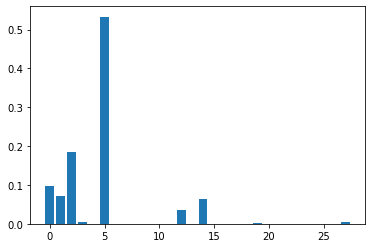

In [32]:
from matplotlib import pyplot
# define dataset
# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Archieve

# SQL Script

In [33]:
from sklearn.tree import export_text

In [34]:
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print node

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(node)? (<ipython-input-34-104c216b393c>, line 30)

In [ ]:
def get_code(tree, feature_names, tabdepth=0):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
#     print("AK",left)
#     print("AK",right)
#     print("AK",threshold)
#     print("AK",features)
#     print("AK",value)
    
    

    def recurse(left, right, threshold, features, node, tabdepth=0):
            if (threshold[node] != -2):
                    print('\t' * tabdepth)
                    print("if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node], tabdepth+1)
                    print('\t' * tabdepth)
                    print ("} else {")
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node], tabdepth+1)
                    print ('\t' * tabdepth)
                    print ("}")
            else:
                    print ('\t' * tabdepth)
                    print ("return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [35]:
clf = DecisionTreeClassifier(random_state=0, max_depth=2, min_samples_leaf = 500)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=2, min_samples_leaf=500, random_state=0)

In [36]:
get_code(clf, FINAL_FEATURES)

NameError: name 'get_code' is not defined

# MOM Gini

In [37]:
gini_dic = {}
predictor_list = []
target_variable = TARGET
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "GM" not in gini_dic: 
            gini_dic["GM"] = []
        if "RGS" not in gini_dic: 
            gini_dic["RGS"] = []
        
        gini_dic["GM"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x][SCORE])-1)*100)
        gini_dic["RGS"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x]["PRED_PROB"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

ERROR
ERROR


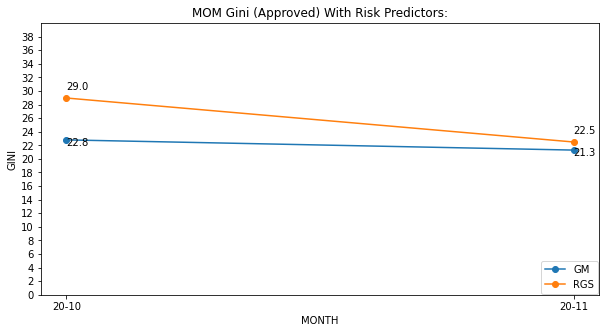

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["GM"], marker='o', scaley = False, label = "GM")
ax1.plot(gini_df["MONTH"],gini_df["RGS"], marker='o', scaley = False, label = "RGS")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM"][i]-0.8))
for i, txt in enumerate(gini_df["RGS"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["RGS"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,40)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,40,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:")
plt.show()

# DOD Gini

In [39]:
gini_df

,index,MONTH,GM,RGS
0,0,20-10,22.797604,28.963060
1,1,20-11,21.296897,22.486924


In [72]:
gini_dic = {}
predictor_list = []
target_variable = TARGET
for x in df["TIME_CREATION_DATE"].unique():
    try:
        if "TIME_CREATION_DATE" not in gini_dic:
            gini_dic["TIME_CREATION_DATE"] = []
        if "GM" not in gini_dic: 
            gini_dic["GM"] = []
        if "RGS" not in gini_dic: 
            gini_dic["RGS"] = []
        
        gini_dic["GM"].append((2*roc_auc_score(df[df["TIME_CREATION_DATE"]==x][target_variable],df[df["TIME_CREATION_DATE"]==x][SCORE])-1)*100)
        gini_dic["RGS"].append((2*roc_auc_score(df[df["TIME_CREATION_DATE"]==x][target_variable],df[df["TIME_CREATION_DATE"]==x]["PRED_PROB"])-1)*100)
        gini_dic["TIME_CREATION_DATE"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "TIME_CREATION_DATE",inplace = True)
gini_df.reset_index(inplace = True)

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


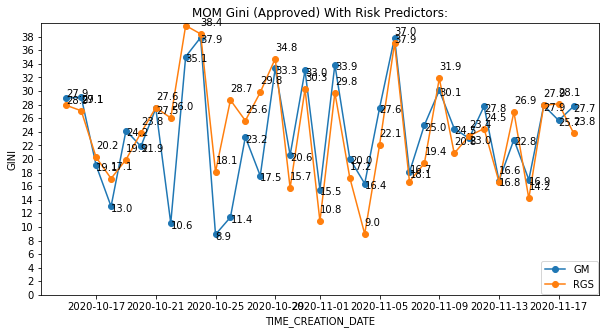

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["TIME_CREATION_DATE"],gini_df["GM"], marker='o', scaley = False, label = "GM")
ax1.plot(gini_df["TIME_CREATION_DATE"],gini_df["RGS"], marker='o', scaley = False, label = "RGS")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["TIME_CREATION_DATE"][i], gini_df["GM"][i]-0.8))
for i, txt in enumerate(gini_df["RGS"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["TIME_CREATION_DATE"][i], gini_df["RGS"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,40)
plt.ylabel("GINI")
plt.xlabel("TIME_CREATION_DATE")
plt.yticks(np.arange(0,40,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:")
plt.show()